In [44]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Modelling
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import xgboost as xgb
from sklearn.model_selection import KFold
import warnings

### Just test some models for now

### Import data

In [45]:
df = pd.read_csv('data/cleaned_data.csv')

In [46]:
df.head()

,Company,TypeName,Inches,Width,Height,isTouchscreen,CpuProducer,CpuSpeed (GHz),MemorySize1,MemoryType1,MemorySize2,MemoryType2,GpuProducer,Ram (GB),Weight (kg),Price_euros
0,Apple,Ultrabook,13.3,2560,1600,False,Intel,2.3,128,SSD,0,NoType,Intel,8,1.4,1339.69
1,Apple,Ultrabook,13.3,1440,900,False,Intel,1.8,128,Flash Storage,0,NoType,Intel,8,1.3,898.94
2,HP,Notebook,15.6,1920,1080,False,Intel,2.5,256,SSD,0,NoType,Intel,8,1.9,575.00
3,Apple,Ultrabook,15.4,2880,1800,False,Intel,2.7,512,SSD,0,NoType,AMD,16,1.8,2537.45
4,Apple,Ultrabook,13.3,2560,1600,False,Intel,3.1,256,SSD,0,NoType,Intel,8,1.4,1803.60


In [78]:
# df = df[~(df['MemoryType2']=="Hybrid") | (df['MemoryType1']=="Hybrid")]
# df.to_csv('data/cleaned_data.csv', index=False)

In [47]:
df.dtypes

Company            object
TypeName           object
Inches            float64
Width               int64
Height              int64
isTouchscreen        bool
CpuProducer        object
CpuSpeed (GHz)    float64
MemorySize1         int64
MemoryType1        object
MemorySize2         int64
MemoryType2        object
GpuProducer        object
Ram (GB)            int64
Weight (kg)       float64
Price_euros       float64
dtype: object

### Prepare X and y variables

In [74]:
X = df.drop(columns=['Price_euros'],axis=1)
y = df['Price_euros']

In [75]:
# define numerical & categorical columns
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

print('We have {} numerical features : {}'.format(len(num_features), num_features))
print('\nWe have {} categorical features : {}'.format(len(cat_features), cat_features))

We have 9 numerical features : Index(['Inches', 'Width', 'Height', 'isTouchscreen', 'CpuSpeed (GHz)',
       'MemorySize1', 'MemorySize2', 'Ram (GB)', 'Weight (kg)'],
      dtype='object')

We have 6 categorical features : Index(['Company', 'TypeName', 'CpuProducer', 'MemoryType1', 'MemoryType2',
       'GpuProducer'],
      dtype='object')


In [50]:
def print_cat(feature):
    print(f"Categories in {feature} variable {len(X[feature].unique())}:      ",end=" " )
    print(X[feature].unique())


In [51]:
for feature in cat_features:
    print_cat(feature=feature)

Categories in Company variable 9:       ['Apple' 'HP' 'Acer' 'Asus' 'Dell' 'Lenovo' 'Other' 'MSI' 'Toshiba']
Categories in TypeName variable 6:       ['Ultrabook' 'Notebook' 'Netbook' 'Gaming' '2 in 1 Convertible'
 'Workstation']
Categories in CpuProducer variable 2:       ['Intel' 'AMD']
Categories in MemoryType1 variable 4:       ['SSD' 'Flash Storage' 'HDD' 'Hybrid']
Categories in MemoryType2 variable 4:       ['NoType' 'HDD' 'SSD' 'Hybrid']
Categories in GpuProducer variable 3:       ['Intel' 'AMD' 'Nvidia']


In [52]:
# from sklearn.preprocessing import LabelEncoder


# # Create an instance of LabelEncoder
# label_encoder = LabelEncoder()

# # Fit label encoder and transform categories
# encoded_categories = label_encoder.fit_transform(df['TypeName'])

# # Print the encoded categories
# print(encoded_categories)


[4 4 3 ... 3 3 3]


In [76]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)




### Create evaliation function 

In [54]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [55]:
# models = {
#     "Linear Regression": LinearRegression(),
#     "K-Neighbors Regressor": KNeighborsRegressor(n_neighbors=11, weights='uniform'),
#     "Decision Tree": DecisionTreeRegressor(),
#     "Random Forest Regressor": RandomForestRegressor(n_estimators=120, bootstrap=True, max_features='sqrt', random_state=1),
#     # "XGBRegressor": XGBRegressor(), 
#     # "CatBoosting Regressor": CatBoostRegressor(verbose=False),
#     # "AdaBoost Regressor": AdaBoostRegressor()
# }
# model_list = []
# r2_list =[]

# for i, model_name in enumerate(models):
#     model = models[model_name]
#     model.fit(X_train, y_train) # Train model

#     # Make predictions
#     y_train_pred = model.predict(X_train)
#     y_test_pred = model.predict(X_test)
    
#     # Evaluate Train and Test dataset
#     model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

#     model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
#     print(model_name)
#     model_list.append(model_name)
    
#     print('Model performance for Training set')
#     print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
#     print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
#     print("- R2 Score: {:.4f}".format(model_train_r2))

#     print('----------------------------------')
    
#     print('Model performance for Test set')
#     print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
#     print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
#     print("- R2 Score: {:.4f}".format(model_test_r2))
#     r2_list.append(model_test_r2)
    
#     print('='*35)
#     print('\n')


In [77]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline

# model_pipeline = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     ("model", RandomForestRegressor(random_state=1))
# ])

# param = {
#         'model__criterion':['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
#         'model__bootstrap': [True],
#         'model__max_features':['sqrt','log2',None],
#         'model__n_estimators': [32,64,128,256]
# }

# gs = GridSearchCV(estimator=model_pipeline, param_grid=param, cv=3, scoring='r2', return_train_score=False)
# gs.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('OneHotEncoder',
                                                                         OneHotEncoder(),
                                                                         Index(['Company', 'TypeName', 'CpuProducer', 'MemoryType1', 'MemoryType2',
       'GpuProducer'],
      dtype='object')),
                                                                        ('StandardScaler',
                                                                         StandardScaler(),
                                                                         Index(['Inches', 'Width', 'Height', 'isTouchscreen', 'CpuSpeed (GHz)',
       'MemorySize1', 'MemorySize2', 'Ram (GB)', 'Weight (kg)'],
      dtype='object'))])),
                                       ('model',
                                        RandomForestRegressor(random_state=1))]),
             param_grid={'model__bootstrap': [True],
                         'model__criterion': ['squared_error', 'absolute_error',
                                              'friedman_mse', 'poisson'],
                         'model__max_features': ['sqrt', 'log2', None],
                         'model__n_estimators': [32, 64, 128, 256]},
             scoring='r2')

In [56]:
kf = KFold(n_splits=5, shuffle=True, random_state=2)
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=1.0),
    "K-Neighbors Regressor": KNeighborsRegressor(n_neighbors=10, weights='distance'),
    "Decision Tree": DecisionTreeRegressor(min_samples_leaf=3, random_state=1),
    "Random Forest Regressor": RandomForestRegressor(n_estimators=100, bootstrap=True, max_features='sqrt', random_state=1),
    "XGBRegressor": xgb.XGBRegressor(objective= 'reg:squarederror', n_estimators=100, max_depth=6, learning_rate=0.1,
                                      random_state=2), 
    # "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=1, max_features='sqrt',
                                                           n_estimators=100, learning_rate=0.1)
}

model_performance = {'Linear Regression': [], "Ridge Regression": [], "Lasso Regression": [], 'K-Neighbors Regressor': [], 
                     'Decision Tree': [], 'Random Forest Regressor': [],"XGBRegressor": [], 'GradientBoostingRegressor': []}


for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)

    for model_name in models:
        model = models[model_name]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Evaluate Train and Test dataset
        model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

        model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

        
        print(model_name)
      
        
        print('Model performance for Training set')
        print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
        print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
        print("- R2 Score: {:.4f}".format(model_train_r2))

        print('----------------------------------')
        
        print('Model performance for Test set')
        print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
        print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
        print("- R2 Score: {:.4f}".format(model_test_r2))
        model_performance[model_name].append(model_test_r2)
        
        print('='*35)
        print('\n')


Linear Regression
Model performance for Training set
- Root Mean Squared Error: 346.8979
- Mean Absolute Error: 251.4032
- R2 Score: 0.7548
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 354.5001
- Mean Absolute Error: 260.5708
- R2 Score: 0.7442


Ridge Regression
Model performance for Training set
- Root Mean Squared Error: 346.8666
- Mean Absolute Error: 250.8647
- R2 Score: 0.7548
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 355.1108
- Mean Absolute Error: 260.7108
- R2 Score: 0.7433


Lasso Regression
Model performance for Training set
- Root Mean Squared Error: 347.8315
- Mean Absolute Error: 250.5759
- R2 Score: 0.7535
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 356.2550
- Mean Absolute Error: 261.0745
- R2 Score: 0.7417


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 53.2687
- Mean Absolute Error: 15

In [57]:
model_list = model_performance.keys()
r2_list = list(map(lambda x: np.average(x), list(model_performance.values())))

### Result

In [58]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
5,Random Forest Regressor,0.832917
6,XGBRegressor,0.827872
7,GradientBoostingRegressor,0.820906
3,K-Neighbors Regressor,0.776608
4,Decision Tree,0.746965
2,Lasso Regression,0.734165
1,Ridge Regression,0.731385
0,Linear Regression,0.729681


### Choose RandomforestRegressor

In [59]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=42)
X_train.shape, X_test.shape

((1146, 15), (128, 15))

In [60]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [61]:
rf = RandomForestRegressor(n_estimators=100, bootstrap=True, max_features='sqrt', random_state=1)
rf= rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 78.51


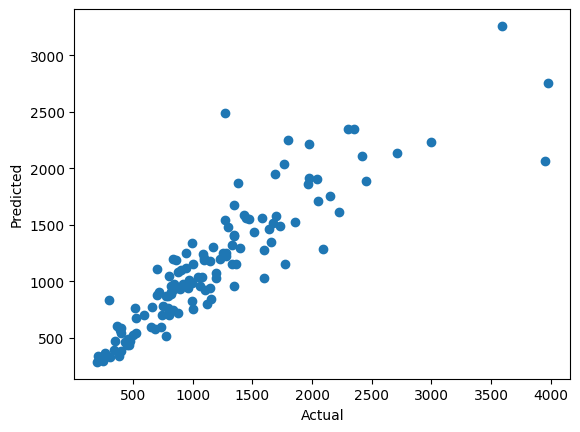

In [62]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

### Difference between predicted and actual values

In [63]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
309,469.00,438.393067,30.606933
622,776.00,514.069529,261.930471
184,1199.00,1026.169000,172.831000
705,795.00,868.303833,-73.303833
522,1279.73,1245.746300,33.983700
...,...,...,...
29,896.00,929.360000,-33.360000
31,199.00,286.588600,-87.588600
286,1097.00,1202.445176,-105.445176
599,1763.00,2039.453700,-276.453700
